# Identify relationships between Prostate cancer associated SNPs and genes

In [1]:
# Load the required packages
from neo4j import GraphDatabase
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

## Setting parameters and creating connection to Neo4J

In [2]:
# Set the genomic parameters
delta_bp = 2000000
FC_cutoff = 1.5
FDR_cutoff = 0.0001
min_expression = 82

# Set up the provenance parameters
Min_pub_number = 1
Min_journal_impact_factor = 0

In [3]:
# Setup a connection to the database
driver = GraphDatabase.driver("bolt://localhost:7687")
session =  driver.session()

## Loading and modifying the reference set

In [4]:
# Read in the data of Farashi et al. that is used as a reference set
farashi = pd.read_excel("Input sets/Farashi/41568_2018_87_MOESM1_ESM-3.xls", header = 1)

# Remove the empty rows at the bottom
farashi = farashi[farashi["SNP ID"].notnull() & farashi["Target/assigned/e-Gene"].notnull()]

### Updating gene names and SNP ID's in reference set

Not all gene names appear to be correct, and could therefore be found in PathwayStudio. These were therefore searched on https://www.ncbi.nlm.nih.gov/gene/ to identify their updated names, as described in their "Aliases" or "Also known as" names. Entries were always filtered based upon species, i.e. homo sapiens.

In [5]:
# Create separate entries for cells with delimited genes
farashi["Target/assigned/e-Gene"] = farashi["Target/assigned/e-Gene"].str.replace(", ", ";")
farashi = farashi.assign(gene=farashi["Target/assigned/e-Gene"].str.split(';')).explode('gene')

# One gene has as postfix "FoxA1 binding", which we manually remove
farashi.drop(farashi[farashi["gene"] == "FoxA1 binding"].index, inplace = True)

# Strip whitespaces
farashi["gene"] = farashi["gene"].str.strip()

# Some gene names are outdated/erroneous. These are manually mapped to correct genes as decribed above
gene_replacement_dictionary = { "MSMB1" : "MSMB",
                                "MSMB2" : "MSMB",
                                "NCOA4-1" : "NCOA4P1",
                                "NCOA4-3" : "NCOA4P3", 
                                "ANKRD5" : "ANKEF1", 
                                "C6orf228" : "SMIM13",
                                "HoxB13" : "HOXB13",
                                "LASS2" : "CERS2",
                                "C10orf32" : "BORCS7",
                                "LOC100505761" : "RPARP-AS1",
                                "LOC100505495" : "PCAT19",
                                "WDR52" : "CFAP44",
                                "HCG4P6" : "HCG4B",
                                "LOC285830" : "HLA-F-AS1",
                                "RAB7L1" : "RAB29",
                                "LOC284578" : "MFSD4A-AS1",
                                "AGAP7" : "AGAP7P",
                                "C2orf43" : "LDAH",
                                "FAM96B" : "CIAO2B",
                                "TMEM180" : "MFSD13A",
                                "WBSCR27" : "METTL27",
                                "KLK3 (PSA)" : "KLK3",
                                "PCAT1 (lncRNA)" : "PCAT1",
                                "SUV420H1" : "KMT5B",
                                "c-MYC" : "MYC",
                                "AL391261.1" : "NCOA4P1"}

farashi["gene"] = farashi["gene"].replace(gene_replacement_dictionary)

In [6]:
# Replace fault-inducing postfixes for snp data
farashi["SNP ID"] = farashi["SNP ID"].str.strip()
farashi["SNP ID"].replace("(_A)|(_C)", "", regex = True, inplace = True)

# Remove entries without valid rs identifiers
farashi.drop(farashi[farashi["SNP ID"].str.startswith("chr")].index, inplace = True)

Similar to the genes, some of the SNP ID's need to be updated as well, as they have been merged with other rs identifiers

These invalid rs identifiers can be found in the next step, where dbSNP is queried.
These missing rs identifiers were subsequently queried on https://www.ncbi.nlm.nih.gov/snp/, where their updated rs identifier was retrieved.

Nonetheless, some rs identifiers could not be found on the dbsnp at all, even to map it. These were removed from the reference set.

In [7]:
# Create a mapping dictionary
snp_replacement_dictionary = {"rs565245309" : "rs10700825",
                              "rs397764955" : "rs11371876",
                              "rs567544918" : "rs143009074",
                              "rs68007409" : "rs58061354",
                              "rs576874987" : "rs2735090",
                              "rs56969947" : "rs5794883",
                              "rs71390080" : "rs35883900",
                              "rs397885676" : "rs35853071",
                              "rs563936332" : "rs11425106",
                              "rs570238728" :  "rs2735091",
                              "rs386572937" : "rs2735095",
                              "rs368454874" : "rs5875242",
                              "rs576956856" : "rs557303655",
                              "rs527768094" : "rs3115587",
                              "rs34421549" : "rs11281315",
                              "rs543833159" : "rs9261476",
                              "rs573341295" : "rs3083610",
                              "rs397841490" : "rs3839562",
                              "rs72562630" : "rs10643878",
                              "rs67276543" : "rs34884832",
                              "rs113645266" : "rs6557271",
                              "rs540840764" : "rs9278594",
                              "rs145076668" : "rs34837204",
                              "rs79588872" : "rs35538902",
                              "rs397847839" : "rs35826034",
                              "rs551993434" : "rs11371951",
                              "rs113130272" : "rs11153141",
                              "rs114376585" : "rs3096702",
                              "rs527588882" : "rs9278592",
                              "rs144721865" : "rs9368661",
                              "rs572291073" : "rs2571388",
                              "rs376201080" : "rs142474496",
                              "rs34948850" : "rs10688614",
                              "rs397887654" : "rs36076724",
                              "rs114473420" : "rs3135340",
                              "rs371043306" : "rs145380596",
                              "rs572943237" : "rs11421756",
                              "rs139078838" : "rs9501073",
                              "rs539183916" : "rs2437062",
                              "rs386410791" : "rs141020575",
                              "rs141507970" : "rs9267919",
                              "rs397823414" : "rs35850123",
                              "rs63475060" : "rs5875246",
                              "rs139104997" : "rs9261481",
                              "rs150282463" : "rs13137700",
                              "rs143466021" : "rs9269108",
                              "rs5875234" : "rs3058350"
                             }

not_found_dbsnp = {"rs77010356", "rs60284051", "rs563604877"}

# Strip whitespaces
farashi["SNP ID"] = farashi["SNP ID"].replace(snp_replacement_dictionary)

In [8]:
# Get the SNP properties from dbsnp
import myvariant
mv = myvariant.MyVariantInfo()
   
dbsnp = mv.querymany(list(set(farashi["SNP ID"])), scopes='dbsnp.rsid', fields='dbsnp', returnall = True)
print("PASSED: Only known SNPs missing") if not_found_dbsnp == set(dbsnp["missing"]) else print("ERROR: New SNPs missing")

querying 1-1000...done.
querying 1001-1139...done.
Finished.
482 input query terms found dup hits:
	[('rs1320961', 2), ('rs11352831', 5), ('rs2292884', 2), ('rs3740414', 2), ('rs1010442', 3), ('rs1221
3 input query terms found no hit:
	['rs77010356', 'rs563604877', 'rs60284051']
PASSED: Only known SNPs missing


In [9]:
# Merge the dbSNP data with the reference set
dbsnp_tab = pd.DataFrame(dbsnp["out"])

# Drop the rs ids that were not found
dbsnp_tab.drop(dbsnp_tab[dbsnp_tab["notfound"] == True].index, inplace = True)

dbsnp_tab["chromosome"] = dbsnp_tab["dbsnp"].apply(lambda x: x["chrom"])
dbsnp_tab["location"] = dbsnp_tab["dbsnp"].apply(lambda x: x["hg19"]["start"] if "hg19" in x.keys() else None)
dbsnp_tab["ref"] = dbsnp_tab["dbsnp"].apply(lambda x: x["ref"])
dbsnp_tab["alt"] = dbsnp_tab["dbsnp"].apply(lambda x: x["alt"])

# Drop entries that do not have a chromosome location
dbsnp_tab.drop(dbsnp_tab[dbsnp_tab["location"].isnull()].index, inplace = True)
dbsnp_tab["location"] = dbsnp_tab["location"].astype(int)

positives = farashi.merge(dbsnp_tab[["query", "chromosome", "location", "ref", "alt"]], how = "inner", left_on = "SNP ID", right_on = "query")

### Properties of the reference set

First, we take a look at the reshaped reference set that was created in the previous step.
We try to find out how many SNPs target a specific gene, and how many genes a SNP targets. 

We also take a look on which part of the genome the SNPs are located

#### Take a look where the SNP is located on the genome

SNP's Genomic Location
184bp 5' of 7SK                     1
21kb 5' of MBD2                     1
missense                            1
3' UTR, ncRNA_intronic              1
intergenic risk region in 8q24      1
34kb 3' of TSHZ1                    1
5' UTR                              1
intergenic                          1
UTR5                                1
Up/downstream region                1
Upstream region                     1
inrtonic, 5' UTR                    1
intergenic (enhancer)               2
upstream region                     4
ncRNA_exonic                        5
3'UTR                               6
5' UTR                              9
exonic                              9
promoter                           11
Coding region                      14
ncRNA_intronic                     23
3' UTR                             28
upstream                           30
inrtonic                           34
downstream                         41
intergenic                 

<AxesSubplot:xlabel="SNP's Genomic Location">

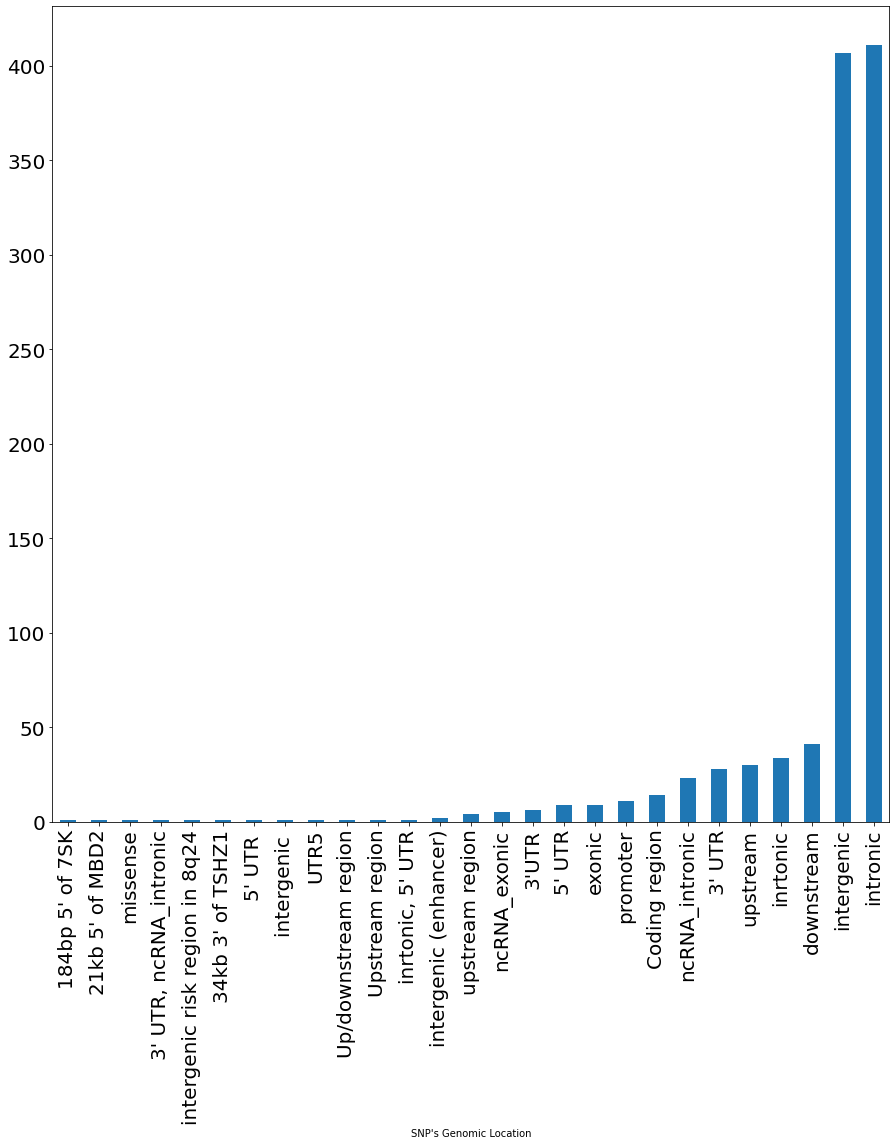

In [10]:
SNP_locations_on_genome = positives.groupby("SNP's Genomic Location")["SNP ID"].nunique().sort_values()
print(SNP_locations_on_genome)
SNP_locations_on_genome.plot.bar(figsize = (15,15), fontsize = 20)

As can be seen, the overwhelming majority of the SNPs are located on the intronic part of the genome.
However, we also see a small number of SNPs located in the coding reagon and the exons.

The genes targeted by these SNPs are obvious, and not part of our objective.

#### Number of genes targeted by each SNP
Next, we take a look at the number of genes that are targeted by each SNP

Quantiles


0.25    1
0.50    1
0.75    2
1.00    6
Name: gene, dtype: int64

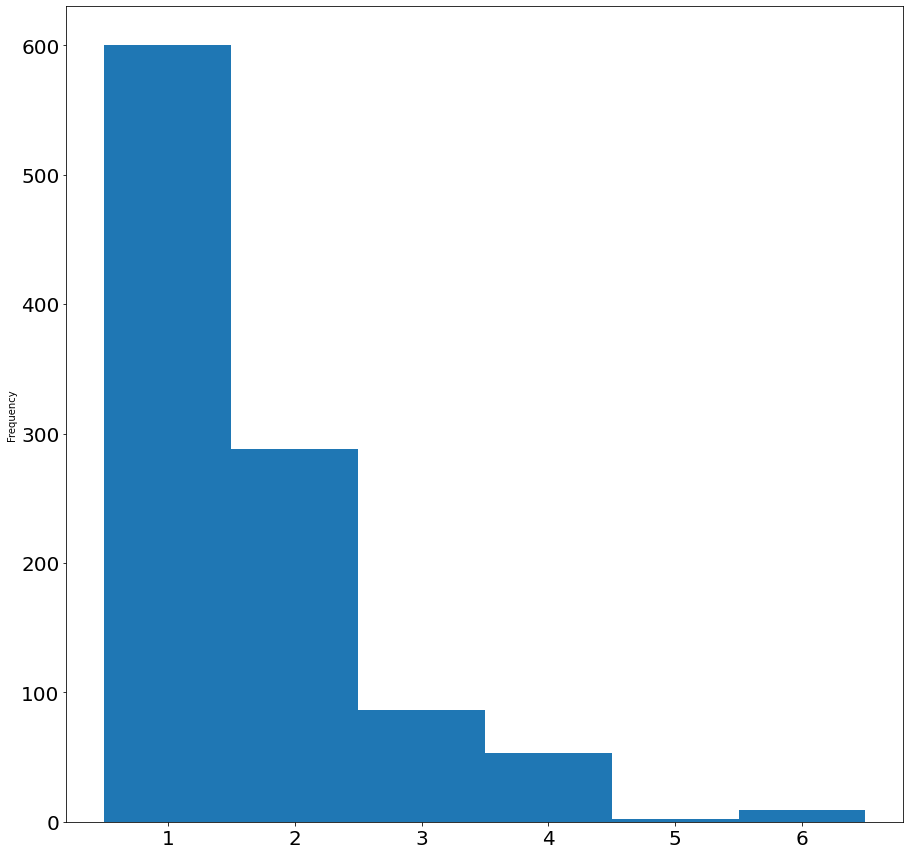

In [11]:
genes_per_snp = positives.groupby("SNP ID")["gene"].nunique()
genes_per_snp.plot.hist(figsize = (15,15), align = "left", bins = range(1,8), fontsize = 20)
print("Quantiles")
genes_per_snp.quantile(q = [0.25, 0.5, 0.75, 1]).astype(int)

SNPs overwhelmingly target only one or two genes, which appears to be in line with what we know from literature.

#### Number of SNPs targeting a each gene
Next, we take a look at the number of SNPs targeting each gene.

Quantiles


0.25      1.0
0.50      1.0
0.75      3.0
1.00    149.0
Name: SNP ID, dtype: float64

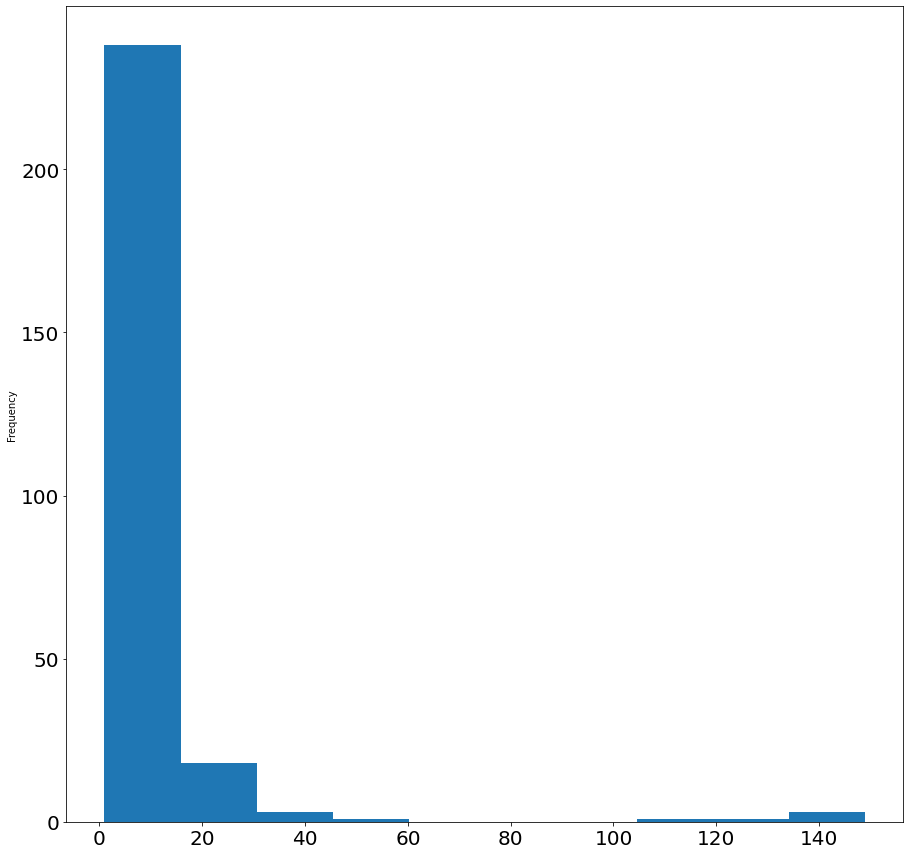

In [12]:
snps_per_gene = positives.groupby("gene")["SNP ID"].nunique()
snps_per_gene.plot.hist(figsize = (15,15), fontsize = 20)
print("Quantiles")
snps_per_gene.quantile(q = [0.25, 0.5, 0.75, 1])

Here we see an enormously skewed distribution, with at its maximum 149 SNPs targeting a single gene.

We therefore group the results by both their studies and experimental methods, to investigate what causes this skewed distribution.

<AxesSubplot:title={'center':'Mean number of SNPs per gene based on reference'}, xlabel='reference'>

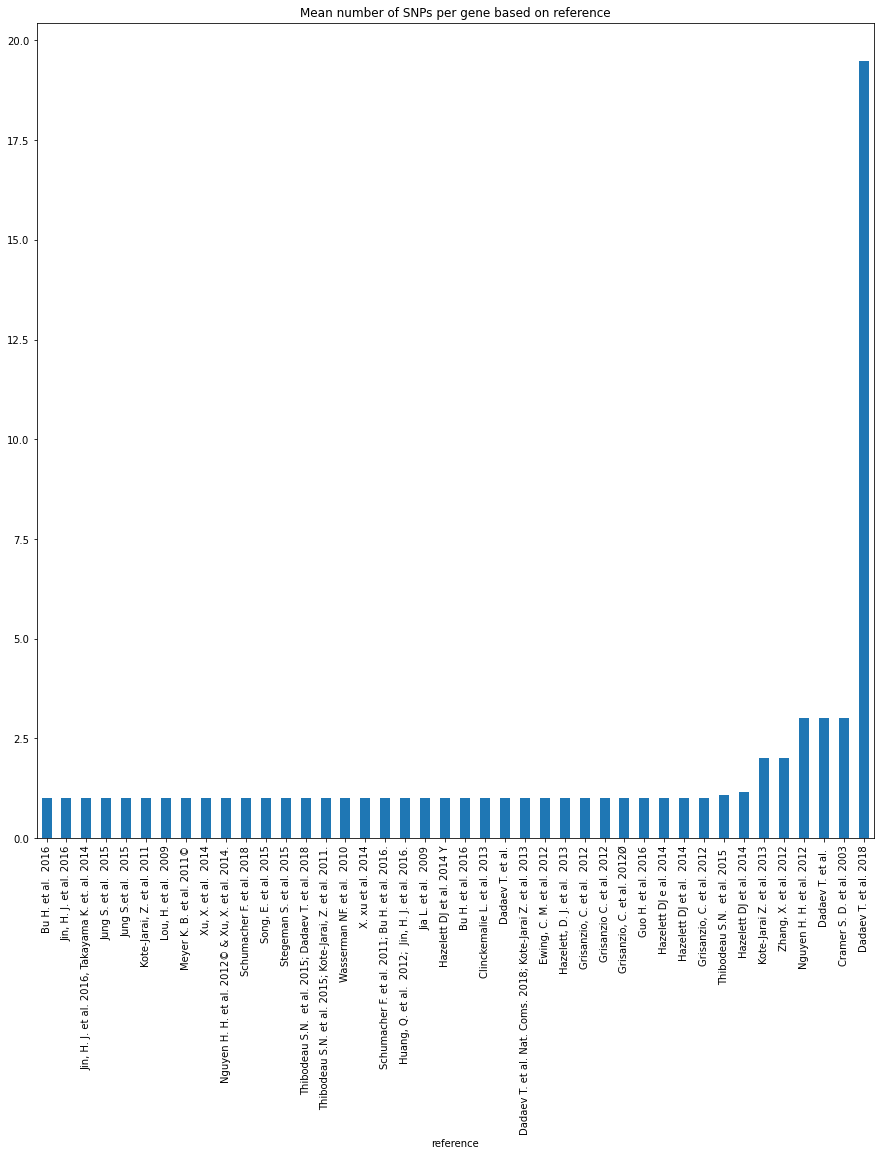

In [13]:
# Reference based
ref = positives.groupby(["reference", "gene"])["SNP ID"].nunique()
ref.mean(level = 0).sort_values().plot.bar(figsize = (15, 15), title = "Mean number of SNPs per gene based on reference")

<AxesSubplot:title={'center':'Mean number of SNPs per gene based on study type'}, xlabel='Expeimental approach'>

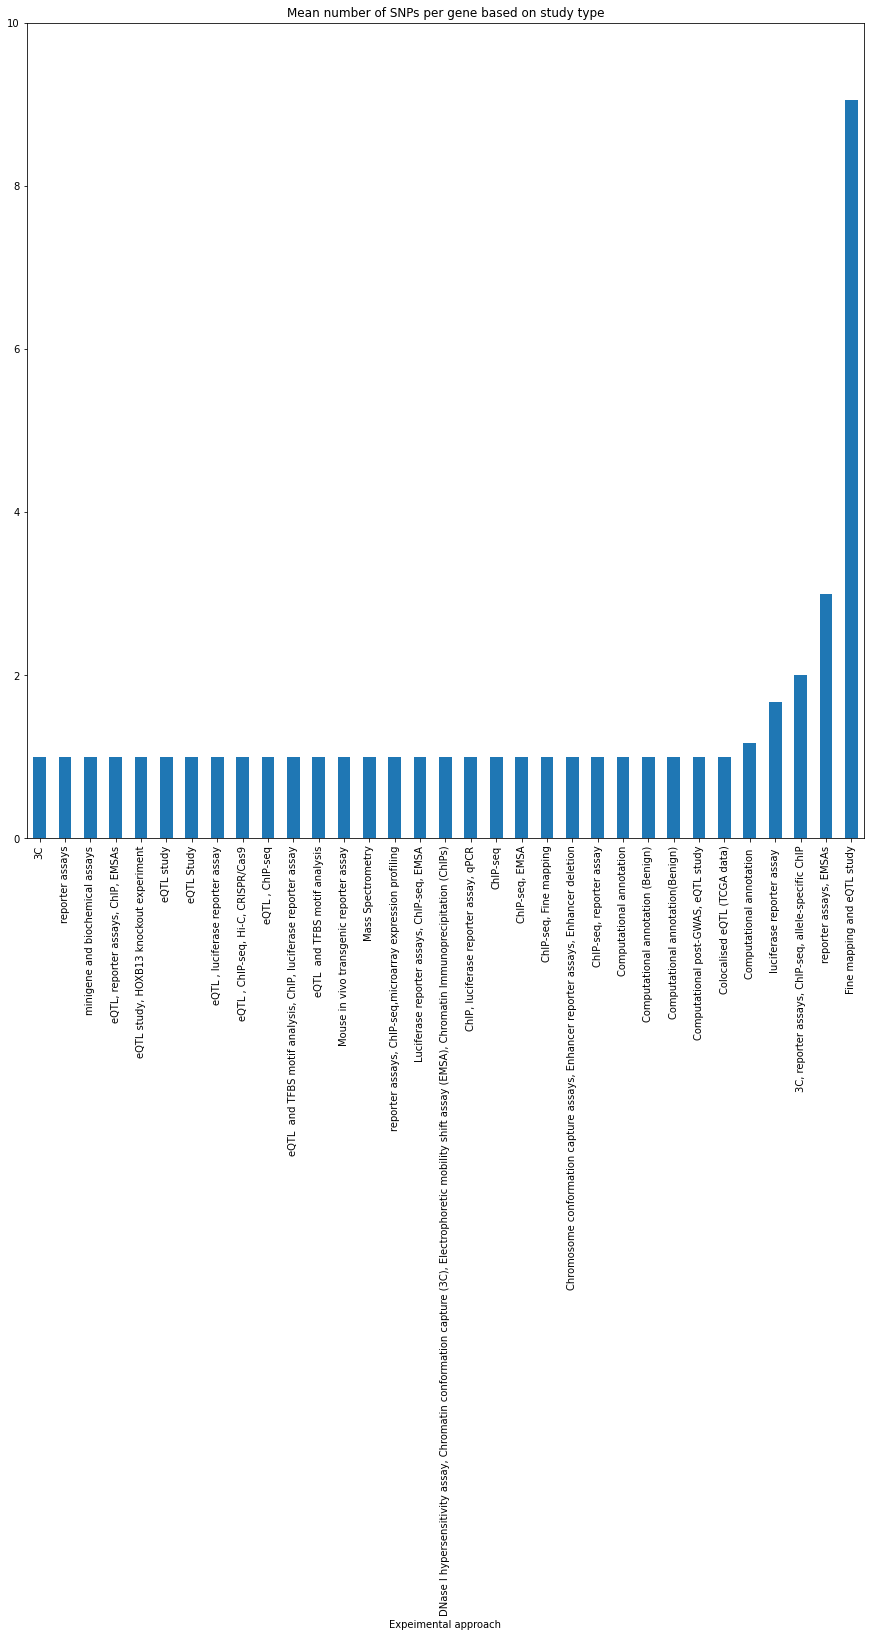

In [14]:
# Method based
method = positives.groupby(["Expeimental approach", "gene"])["SNP ID"].nunique()
method.mean(level = 0).sort_values().plot.bar(figsize = (15, 15), title = "Mean number of SNPs per gene based on study type", ylim = (0,10))

Based on the figures above, it appears that both the study of Dadaev as well as the Fine mapping and eQTL study method are outliers in the number of SNPs that target each gene.
However, these data are not independent from each other, as Dadaev's study design was based on Fine mapping and eQTL study.
Furthermore, because the mean of Dadaev's study is higher than the one of the experimental method, it is likely that Dadaev's study skews the mean of the Fine mapping and eQTL study, rather than the other way around.

Therefore, we investigate what happens to the number of SNPs targeting each gene when we exclude Dadaev's study from the reference set.

<AxesSubplot:title={'center':'Mean number of SNPs per gene based on study type, study of Dadaev et al. excluded'}, xlabel='Expeimental approach'>

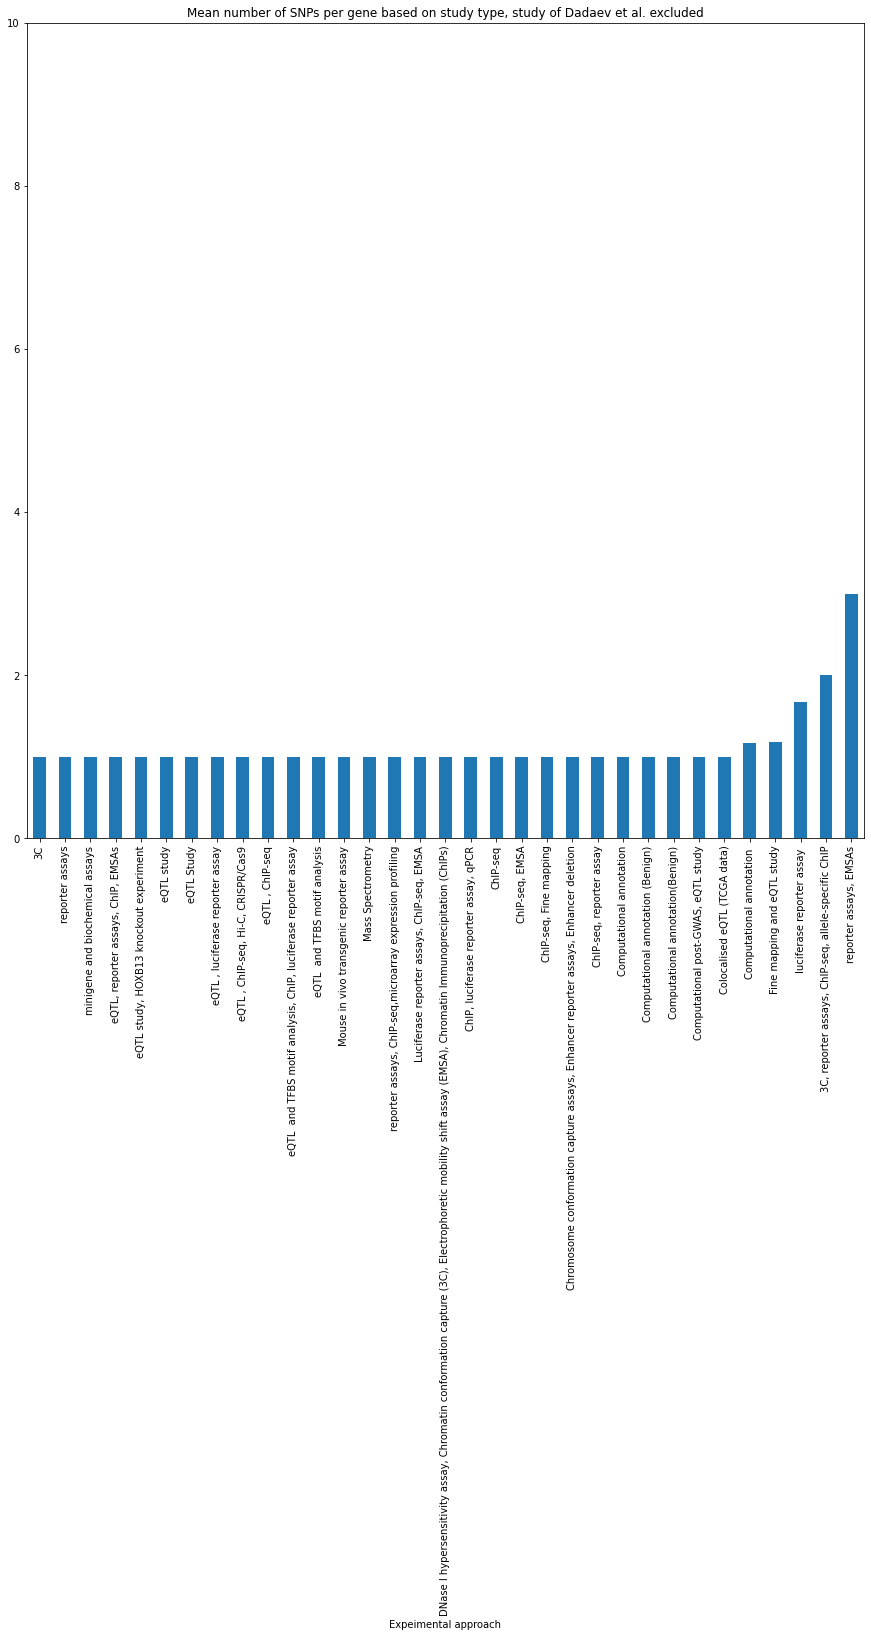

In [15]:
#TODO: Kijken of de studies van Dadaev hetzelfde artikel zijn

no_dadaev = positives[~positives["reference"].isin(["Dadaev T. et al. 2018", "Dadaev T. et al."])].groupby(["Expeimental approach", "gene"])["SNP ID"].nunique()
no_dadaev.mean(level = 0).sort_values().plot.bar(figsize = (15, 15), title = "Mean number of SNPs per gene based on study type, study of Dadaev et al. excluded", ylim = (0,10))

With the study of Dadaev excluded, the Fine mappign and eQTL study method is no longer an outlier in the number of SNPs that target each gene.

#### Filtering the reference set
Based on the findingds above, we can define two filters:

1. We remove all entries that are found on the coding part of the genome
2. We remove all entries that were based upon the study by Dadaev

In [16]:
# Remove entries that are based on a single eQTL study, or that are found in the exon/coding region
Dadaev = ["Dadaev T. et al. 2018", "Dadaev T. et al."]
coding_snps = ["Coding region", "exonic"]

positives = positives[(~positives["reference"].isin(Dadaev)) & (~positives["SNP's Genomic Location"].isin(coding_snps))]

### Properties of the modified reference set

We now describe the properties of the modified reference set, and investigate whether we can map it to the nodes in PathwayStudio.

In [17]:
positives_statistics = pd.DataFrame({"Number of unique SNPs" : len(set(positives["SNP ID"])),
                                     "Number of unique genes" : len(set(positives["gene"])), 
                                     "Number of unique SNP-gene pairs" : len(positives[["SNP ID", "gene"]].drop_duplicates()),
                                     "Mean number of SNPs per gene" : round(len(set(positives["SNP ID"])) / len(set(positives["gene"])), 1)
                                    }.items(), columns = ["Statistic", "Value"])
print(positives_statistics)

                         Statistic  Value
0            Number of unique SNPs  237.0
1           Number of unique genes  217.0
2  Number of unique SNP-gene pairs  262.0
3     Mean number of SNPs per gene    1.1


<AxesSubplot:title={'center':'Chromosome on which the SNP is located'}>

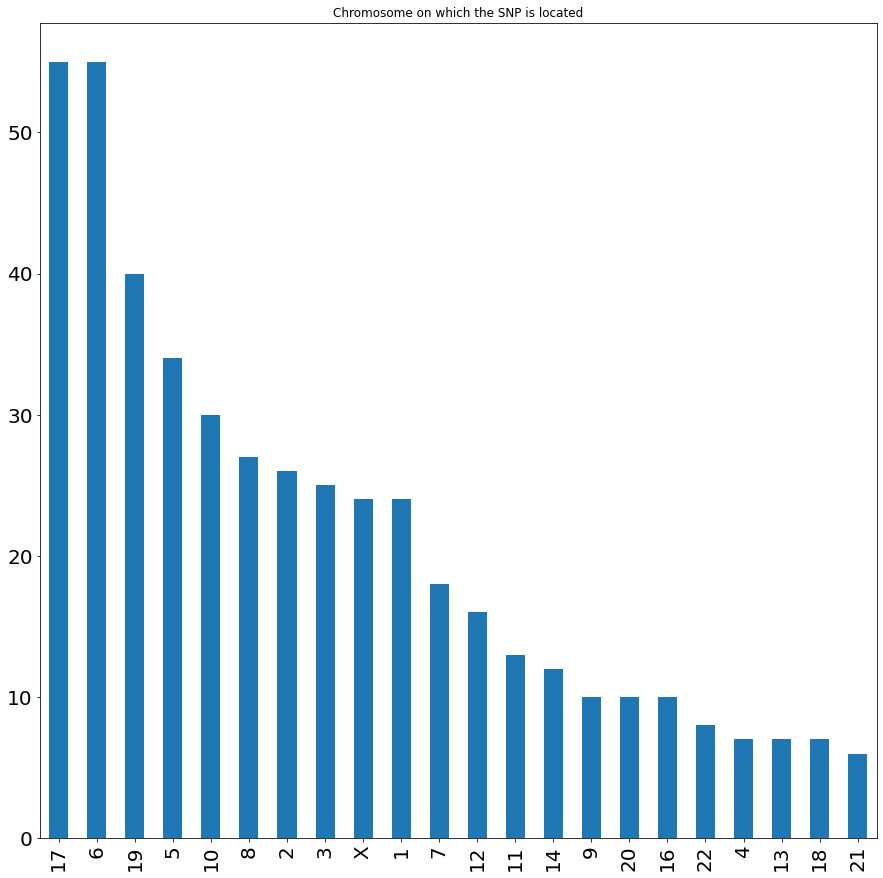

In [18]:
# Show where the positives are located
positives["chromosome"].value_counts().plot.bar(figsize = (15,15), title = "Chromosome on which the SNP is located", fontsize = 20)

<AxesSubplot:title={'center':'Mutation types From --> To'}>

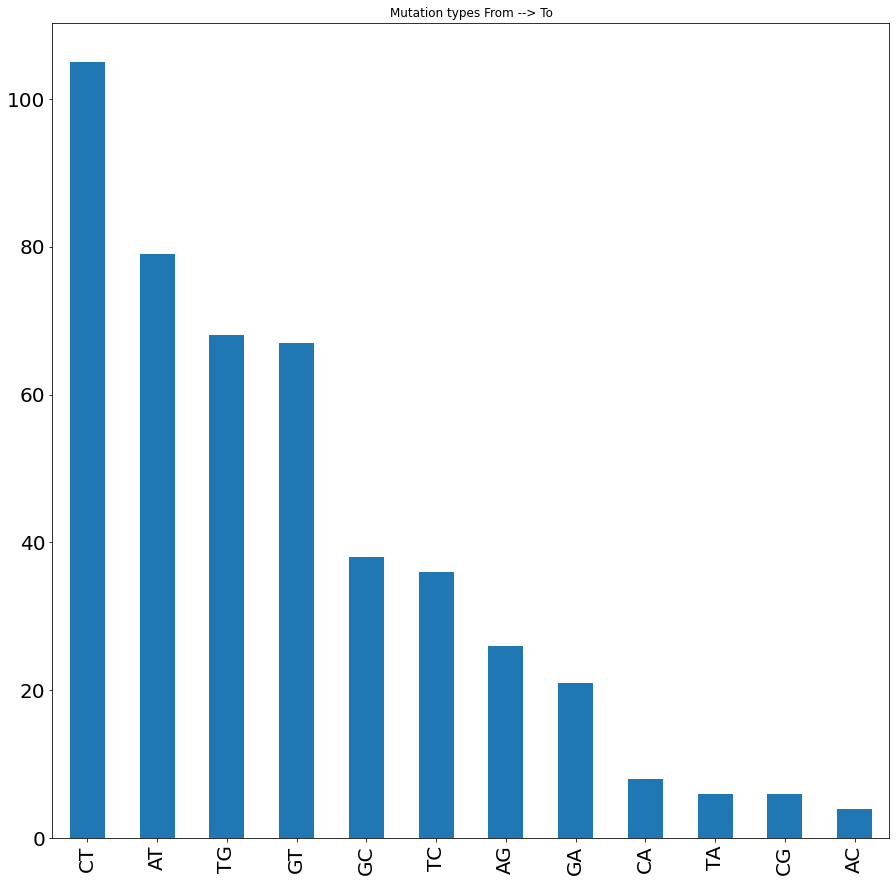

In [19]:
# Plot the types of mutations
mutation_type = positives["ref"] + positives["alt"]
mutation_type.value_counts().plot.bar(figsize = (15,15), title = "Mutation types From --> To", fontsize = 20)

<AxesSubplot:>

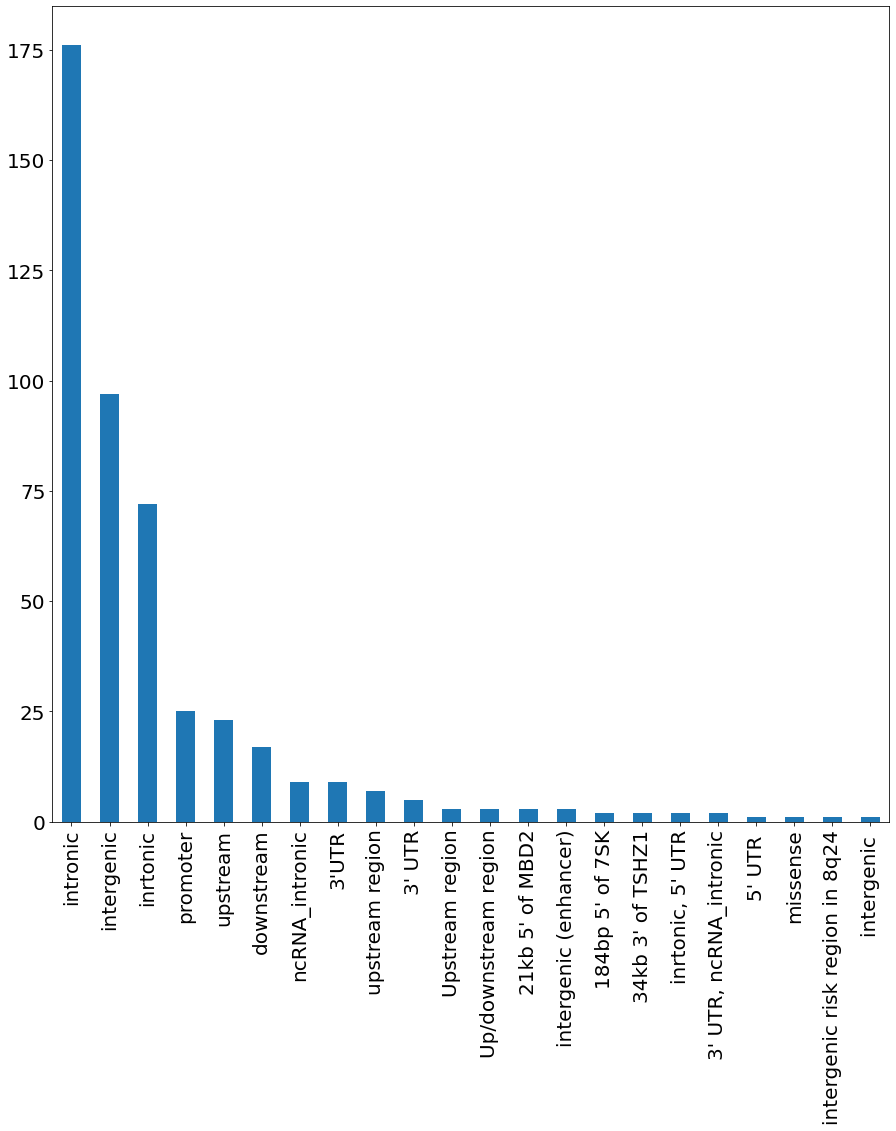

In [20]:
# Plot the genetic region of the SNP
positives["SNP's Genomic Location"].value_counts().plot.bar(figsize = (15,15), fontsize = 20)

In [21]:
# Map the genes to their node identifiers
nodes = session.run("Match (n) WHERE n.name IN " + str(list(set(farashi["gene"]))) + " RETURN n").value()
# Validate the mappings
known_unmappable_genes = {"MFSD4A-AS1", "NCR00171"}
print("Mapping succesful, only known genes MFSD4A-AS1 and NCR00171 unsuccesfully mapped") if set(farashi["gene"]) - set([x["name"] for x in nodes]) == known_unmappable_genes else print("Mapping incomplete")

Mapping succesful, only known genes MFSD4A-AS1 and NCR00171 unsuccesfully mapped


## Gene expression data

Now that we have our positive cases, we create negative cases.
We do so based on gene-expression data that was obtained from a separate Next-Generation sequencing dataset, which compared the expression of men with prostate cancer, to that of men without prostate cancer.

For every gene, its location and whether it is protein coding is obtained.

In [22]:
# Extract the gene expression data
cols = pd.read_csv("Input sets/Gene expression data/design_matrix_prostate_unpaired.txt", delimiter = "\t")
reads = pd.read_csv("Input sets/Gene expression data/expression_matrix_prostate_clean.txt", delimiter = "\t")
# Read in the differential expression calculations
dex = pd.read_csv("Input sets/Gene expression data/Galaxy37-[edgeR_DGE_on_2__design_matrix_prostate_unpaired.txt_-_differentially_expressed_genes].tabular.annotated.txt", 
                  delimiter = "\t", index_col = 0, names = ["ENSEMBL", "gene", "logFC", "logCPM", "LR", "pValue", "FDR"], header = 0)
dex["ENSEMBL"].replace("(\.\d+)", "", regex = True, inplace = True)
# We know that the logFC is a 2 log. However, I prefer absolute values rather than logs
dex["FC"] = 2**dex["logFC"]

# Assign differential expression to the genes based on the previously set parameters
dex["Diff expression"] = "Unchanged"
dex.loc[(dex["FDR"] <= FDR_cutoff) & (dex["FC"] <= 1/FC_cutoff), "Diff expression"] = "Underexpressed"
dex.loc[(dex["FDR"] <= FDR_cutoff) & (dex["FC"] >= FC_cutoff), "Diff expression"] = "Overexpressed"

# Get the raw reads data
reads["total"] = reads.sum(axis = 1, numeric_only = True)
reads["freq"] = ((reads[list(cols["samplename"])] > 0) * 1).sum(axis = 1)
reads["gene_ids"].replace("(\.\d+)", "", regex = True, inplace = True)

reads = reads.merge(dex, left_on = "gene_ids", right_on = "ENSEMBL", how = "outer")

The reads data loaded above describes how many transcrips of a certain gene have been found in both healthy as well as carcinogenic prostate cells. In total, 92 sameples are taken, of which 42 were healthy, and 50 were from prostate cancer samples.

We investigate in which proportion of the prostate cancer samples the genes from our positive set are expressed.

Quantiles
0.10    92.0
0.25    92.0
0.50    92.0
0.75    92.0
1.00    92.0
Name: freq, dtype: float64


<AxesSubplot:>

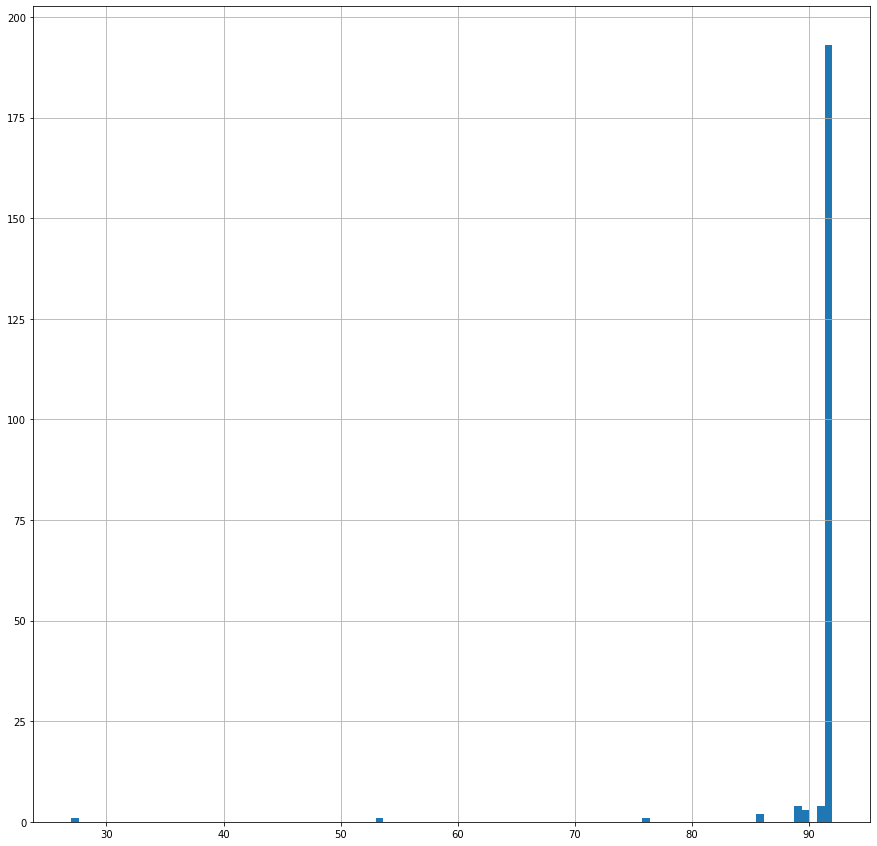

In [23]:
# See to which degree the 
print("Quantiles")
print(reads["freq"][reads["gene"].isin(positives["gene"])].quantile([0.1,0.25,0.5,0.75,1]))
reads["freq"][reads["gene"].isin(positives["gene"])].hist(figsize = (15,15), bins = 100)

Based on the data above, the overwhelming proportion of the genes in our set of postive cases are expressed in all samples of prostate cells.

Based upon this finding, we can we can consider using the expression of a gene in prostate cells as a filter for our negative cases.

In [24]:
# Initiate the connection to the database (first time you may have to run ensembl.download() and ensembl.index())
# To align with our reference set, we take a Ensembl version from 2019
from pyensembl import EnsemblRelease
ensembl = EnsemblRelease(92)

# Function to extract the data (and prevent superfluous queries)
def getEnsemblData(id):
    try:
        data = ensembl.gene_by_id(id)
        return pd.Series({"gene name" : data.gene_name, 
                          "chromosome" : data.contig, 
                          "gene start" : data.start,
                          "gene stop" : data.end,
                          "protein_coding" : data.is_protein_coding})
    except ValueError:
        return pd.Series({"gene name" : None, 
                          "chromosome" : None, 
                          "gene start" : None,
                          "gene stop" : None,
                          "protein_coding" : None})

In [25]:
# Remove the postifxes of the gene identifiers
reads["gene_ids"].replace("\.\d", "", regex = True, inplace = True)
reads[["gene name", "chromosome", "gene start", "gene stop", "protein_coding"]] = reads["gene_ids"].apply(lambda x: getEnsemblData(x))

# Replace some of the gene names with the updated ones
reads["gene name"].replace(gene_replacement_dictionary, inplace = True)

In [56]:
# Calculate the length of the gene
reads["gene length"] = abs(reads["gene stop"] - reads["gene start"]).astype(int)

In [26]:
# Check whether all genes in the reference set are in the expression data
known_missing_from_reads = {'LOC284581', 'MFSD4A-AS1'}

print("PASSED: Only known missing genes absent in gene expression data") if set(positives["gene"]) - set(reads["gene name"]) == known_missing_from_reads else print("Failed: New missing entries found")

PASSED: Only known missing genes absent in gene expression data


In [27]:
# Remove the genes that are not expressed in prostate cells frequently enough
reads = reads[reads["freq"] >= min_expression]

# Drop the mitochondrial genes and the entries that could not be found
reads.drop(reads[reads["chromosome"].isin(["MT", None])].index, inplace = True)

In [28]:
# Create a dataframe of all combinations of SNPs and genes that are on the same chromosome
positives["location"] = positives["location"].astype(int)
snp_candidates = positives[["SNP ID", "chromosome", "location", "gene"]].merge(reads[["gene_ids", "gene name", "chromosome", "gene start", "gene stop", "gene length", "FC", "FDR", "Diff expression"]], on = "chromosome", how = "inner")

# Drop all entries that do not describe an unique pair of SNP and gene.
# If gene start/stop would also be used to determine duplicates, at most 57 extra entries would be there. 
# This number is considered to be insignificant.
snp_candidates.drop_duplicates(["SNP ID", "gene name"], keep = "last", inplace = True)

# Select the pairs where the SNP window and the gene windows overlap
snp_candidates["candidate"] = snp_candidates.apply(lambda x: True if ((x["gene stop"] >= x["location"] - delta_bp and x["gene stop"] <= x["location"] + delta_bp) or 
                                                                      (x["gene start"] >= x["location"] - delta_bp and x["gene start"] <= x["location"] + delta_bp)) else False, axis = 1)
snp_candidates.drop(snp_candidates[snp_candidates["candidate"] == False].index, inplace = True)

In [29]:
# Split up the dataset into cancer and non-cancer samples
cancer = reads[["gene_ids"] + list(cols.samplename[cols.condition == "cancer"])].copy()
normal = reads[["gene_ids"] + list(cols.samplename[cols.condition == "normal"])].copy()

In [130]:
# Mark the entries in the SNP candidates as positives. Also remove all duplicate SNP-gene entries.
positives["Class"] = 1
positives.drop_duplicates(["SNP ID", "gene"], keep = "last", inplace = True)

# Assign reference to set
f = snp_candidates.drop(columns = ["gene", "gene_ids", "candidate"]).merge(positives[["Class", "SNP ID", "gene"]], how = "left", left_on = ["SNP ID", "gene name"], right_on = ["SNP ID", "gene"])
f["Class"].fillna(value = 0, inplace = True)
f["Class"] = f["Class"].astype(int)

# Also removed a column that was only used for merging.
f.drop(columns = "gene", inplace = True)

# Drop all entries that don't have at least one positive case
f = f[f["SNP ID"].isin(f["SNP ID"][f["Class"] == True])]

Class
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bp distance, dtype: object

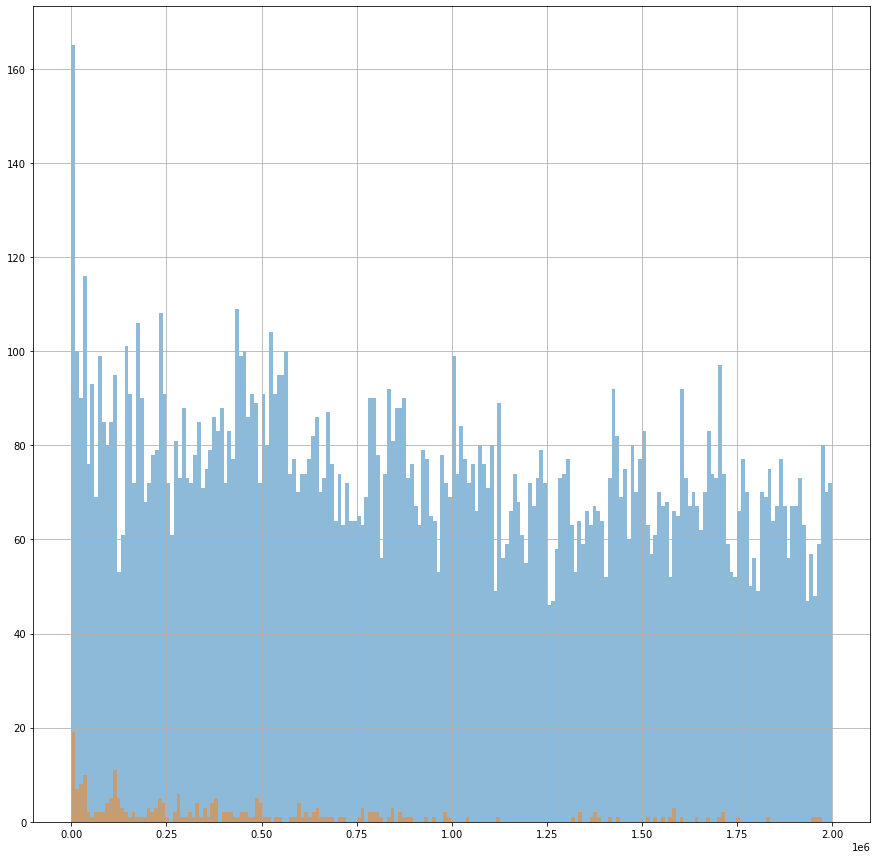

In [131]:
# Calculate the distance between the gene and the SNP
f[["gene start", "gene stop"]] = f[["gene start", "gene stop"]].astype(int)
f["bp distance"] = f.apply(lambda x: min([abs(x["gene start"] - x["location"]), abs(x["gene stop"] - x["location"])]), axis = 1)

f["bp distance"].groupby(f["Class"]).hist(alpha = 0.5, figsize = (15,15), bins = 200)

Class
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Gene rank, dtype: object

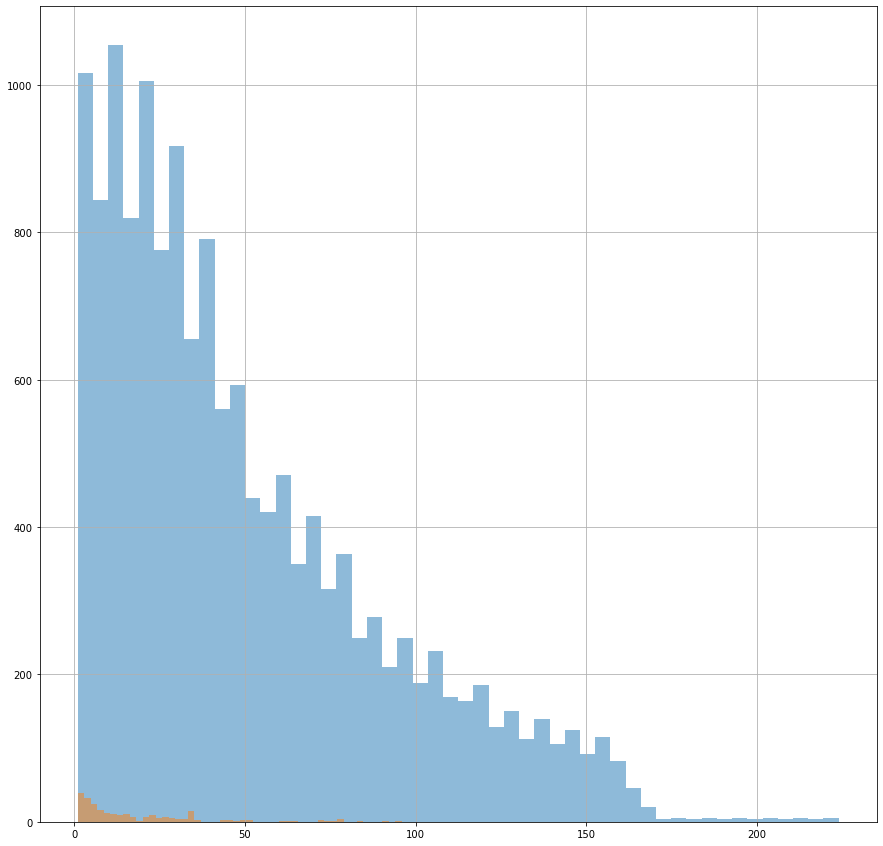

In [132]:
# Calculate the rank of the gene as compared to other genes
f = f.sort_values(["SNP ID", "bp distance"])
f["Gene rank"] = f.groupby("SNP ID").cumcount() + 1

f["Gene rank"].groupby(f["Class"]).hist(alpha = 0.5, figsize = (15,15), bins = 50)

In [133]:
# Compare the differences between ENSEMBL gene names and PathwayStudio gene names
from matplotlib_venn import venn2

pws_names = session.run("Match (p:Protein) RETURN p.name").data()
pws_names = [x["p.name"] for x in pws_names]

venn2(subsets = (len(set(pws_names) - set(reads["gene name"])), 
                 len(set(reads["gene name"]) - set(pws_names)),
                 len(set(pws_names).intersect(set(reads["gene name"])))))

ModuleNotFoundError: No module named 'matplotlib_venn'

## Query all the incoming and outgoing pathway data for the genes and create features based upon them

In [134]:
# Get the incoming and outgoing paths of the genes
direct = pd.DataFrame(session.run("Match p = (n)-[r]-(x:Protein)" +
                                  " WHERE n.name IN " + str(list(f["gene name"])) + 
                                  " RETURN DISTINCT startnode(r).name AS start," +
                                  " type(r) AS relationship," + 
                                  " r.pmid AS pmid," +
                                  " length(r.pmid) AS npmid," + 
                                  " endnode(r).name AS end").data())

In [135]:
# Create features based on direct paths
direct = direct.merge(dex[["gene", "Diff expression"]], left_on = "start", right_on = "gene", how = "inner")
direct = direct.merge(dex[["gene", "Diff expression"]], left_on = "end", right_on = "gene", how = "inner", suffixes = [" start", " end"])

# Create the types of paths
direct["direct_incoming"] = "Incoming_" + direct["relationship"] + "_" + direct["Diff expression start"]
direct["direct_outgoing"] = "Outgoing_" + direct["relationship"] + "_" + direct["Diff expression end"]

# Count the frequencies of the types of paths
direct_incoming = direct[direct["npmid"] >= Min_pub_number].groupby(["end", "direct_incoming"])["start"].nunique().unstack(level = 1, fill_value = 0)
direct_outgoing = direct[direct["npmid"] >= Min_pub_number].groupby(["start", "direct_outgoing"])["end"].nunique().unstack(level = 1, fill_value = 0)

In [34]:
# Merge the features for the direct paths into the feature set
f = f.merge(direct_incoming, how = "left", left_on = "gene name", right_index = True)
f = f.merge(direct_outgoing, how = "left", left_on = "gene name", right_index = True)

In [35]:
# Get the indirect outgoing paths
indirect_outgoing = pd.DataFrame(session.run("Match p = (n)-[r]->(x:Protein)" +
                                                " WHERE n.name IN " + str(list(direct["end"][direct["start"].isin(f["gene name"])])) +
                                                " RETURN DISTINCT startnode(r).name AS start," +
                                                " type(r) AS relationship," +
                                                " r.pmid AS pmid," +
                                                " length(r.pmid) AS npmid," +
                                                " endnode(r).name AS end").data())

# Merge with expression data
indirect_outgoing = indirect_outgoing.merge(dex[["gene", "Diff expression"]], left_on = "end", right_on = "gene", how = "inner")

# Create feature for second step
indirect_outgoing["indirect_outgoing"] = "Outgoing_" + indirect_outgoing["relationship"] + "_" + indirect_outgoing["Diff expression"] 

In [36]:
# Create the features for the two-step outgoing paths
indirect_outgoing = direct[["start", "direct_outgoing", "end"]][direct["npmid"] >= Min_pub_number].merge(indirect_outgoing[["start", "indirect_outgoing", "end"]][indirect_outgoing["npmid"] >= Min_pub_number], how = "inner", left_on = "end", right_on = "start")

# Remove circular paths
indirect_outgoing = indirect_outgoing[indirect_outgoing["start_x"] != indirect_outgoing["end_y"]]

# Create the two-step feature
indirect_outgoing["feature"] = indirect_outgoing["direct_outgoing"] + "_" + indirect_outgoing["indirect_outgoing"]

# Count the frequencies of the indirect outgoing paths
indirect_outgoing_path_counts = indirect_outgoing.groupby(["start_x", "feature"])["end_y"].nunique().unstack(level = 1, fill_value = 0)

In [37]:
# Merge the indirect outgoing path features with the reference set
f = f.merge(indirect_outgoing_path_counts, how = "left", left_on = "gene name", right_index = True)

# Free up memory by deleting the merged pathway data
del indirect_outgoing
del indirect_outgoing_path_counts

In [38]:
# Get the indirect incoming paths
indirect_incoming = pd.DataFrame(session.run("Match p = (y:Protein)-[r]->(n)"
                                                " WHERE n.name IN " + str(list(direct["start"][direct["end"].isin(f["gene name"])])) +
                                                " RETURN DISTINCT startnode(r).name AS start," +
                                                " type(r) AS relationship," +
                                                " r.pmid AS pmid," +
                                                " length(r.pmid) AS npmid," +
                                                " endnode(r).name AS end").data())

# Merge with expression data
indirect_incoming = indirect_incoming.merge(dex[["gene", "Diff expression"]], left_on = "start", right_on = "gene", how = "inner")

# Create feature for second step
indirect_incoming["indirect_incoming"] = "Incoming_" + indirect_incoming["relationship"] + "_" + indirect_incoming["Diff expression"] 

In [39]:
# Create the features for the two-step incoming paths
indirect_incoming = indirect_incoming[["start", "indirect_incoming", "end"]][indirect_incoming["npmid"] >= Min_pub_number].merge(direct[["start", "direct_incoming", "end"]][direct["npmid"] >= Min_pub_number], how = "inner", left_on = "end", right_on = "start")

# Remove circular paths
indirect_incoming = indirect_incoming[indirect_incoming["start_x"] != indirect_incoming["end_y"]]

# Create the two-step feature
indirect_incoming["feature"] = indirect_incoming["indirect_incoming"] + "_" + indirect_incoming["direct_incoming"]

# Count the frequencies of the indirect outgoing paths
indirect_incoming_path_counts = indirect_incoming.groupby(["end_y", "feature"])["start_x"].nunique().unstack(level = 1, fill_value = 0)

In [41]:
# Merge the indirect incoming path features with the reference set
f = f.merge(indirect_incoming_path_counts, how = "left", left_on = "gene name", right_index = True)

# Free up memory by deleting the merged pathway data
del indirect_incoming
del indirect_incoming_path_counts

In [ ]:
# Calculate network statistics such as eigenvector centrality 
# TODO: Alleen genen nemen die tot expressie komen, en alle relaties includeren
eigenvector = "CALL gds.alpha.eigenvector.stream({" +
              " nodeProjection: 'Protein'," +
              " relationshipProjection: 'Regulation'" +
              "})" + 
              " YIELD nodeId, score" + 
              " RETURN gds.util.asNode(nodeId).name AS page, score" + 
              " ORDER BY score DESC"

degree = "CALL gds.alpha.degree.stream({" +
              " nodeProjection: 'Protein'," +
              " relationshipProjection: 'Regulation'" +
              "})" + 
              " YIELD nodeId, score" + 
              " RETURN gds.util.asNode(nodeId).name AS page, score" + 
              " ORDER BY score DESC"

## Query pathway studio for information about Prostate cancer and it's associated pathways, and use it to filter the pathway information

In [61]:
pca = session.run("MATCH (n:Disease) WHERE n.name =~ '^prostate.*' RETURN n.name").data()

# Validate the extracted nodes
print([x["n.name"] for x in pca])

['prostate cancer', 'prostate carcinoma', 'prostate neoplasm']


In [62]:
# Find relationships between the disease nodes --> pathways --> genes
pca_pathways = pd.DataFrame(session.run("MATCH (n)-[r]->(path:Pathway)<-[r2]-(prot:Protein) WHERE n.name =~ '^prostate.*' RETURN DISTINCT path.name AS pathway, prot.name AS gene").data())

# Cross-tabulate the data
pathway_features = pd.crosstab(pca_pathways["gene"], pca_pathways["pathway"])

# Add the pathway information to the feature set
f = f.merge(pathway_features, how = "left", left_on = "gene name", right_index = True)

In [ ]:
# PCA associated proteins
pca_proteins = pd.DataFrame(session.run("MATCH (n)-[r]->(prot:Protein) WHERE n.name =~ '^prostate.*' RETURN DISTINCT type(r) AS relationship, r.pmid AS pmid, length(r.pmid) AS npmid, prot.name AS gene").data())

# Filter relationships based upon minimum number of publications
pca_proteins = pca_proteins[pca_proteins["npmid"] >= Min_pub_number]

# Cross-tabulate the data to make it features
pca_proteins["relationship"] = pca_proteins["relationship"] + "_of_PCA"

pca_protein_features = pca_proteins.groupby(["gene", "relationship"])["npmid"].sum()
pca_protein_features = pca_protein_features.unstack(level = 0)

# Merge with the feature set
f = f.merge(pca_protein_features, how = "left", left_on = "gene name", right_index = True)

# Building a classifier

In [22]:
from sklearn import datasets
iris = datasets.load_iris()

In [23]:
from sklearn.model_selection import train_test_split

data=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})

X=data[['sepal length', 'sepal width', 'petal length', 'petal width']]  # Features
y=data['species']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from sklearn.ensemble import RandomForestClassifier

#Create a Random forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn.model_selection import cross_validate
scores = cross_validate(clf, X, y, scoring = ['precision_macro', 'recall_macro'], cv = 10, n_jobs = -1)

Accuracy: 0.9333333333333333


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

f["chromsome"] = "Chromosome " + f["chromosome"]

encoder = OneHotEncoder()
encoder.fit(f.drop(["SNP ID", "Class", "location", "gene name", "gene start", "gene stop"], axis = 1))

# Create a Random forest Classifier
clf = RandomForestRegressor(n_estimators = 1, n_jobs = -1)

# Perform leave-SNP-out cross validation
SNPs = list(set(f["SNP ID"]))
for snp in SNPs:
    print("Predicting candidates for " + snp)
    f_train = f[f["SNP ID"] != snp].drop(["SNP ID", "Class", "location", "gene name", "gene start", "gene stop"], axis = 1)
    f_test = f[f["SNP ID"] == snp].drop(["SNP ID", "Class", "location", "gene name", "gene start", "gene stop"], axis = 1)
    train_class = f[f["SNP ID"] != snp]["Class"]
    
    clf.fit(encoder.transform(f_train).toarray(), train_class)
    
    outcomes = pd.DataFrame({"predicted" : clf.predict(encoder.transform(f_test)),
                            "reference" :f[f["SNP ID"] == snp]["Class"]})
    

In [6]:
import os, json

# Get all the protein-protein triples with a certain minimum number of sources
PPI = pd.DataFrame(session.run("MATCH (p:Protein)-[r]-(p2:Protein) WHERE length(r.pmid) >= " + str(Min_pub_number) + " RETURN DISTINCT p.name, p2.name").data())
PPI.sort_index(axis=1, inplace=True)
PPI.drop_duplicates(inplace = True)

# Export the edges
PPI.to_csv("~/git/orbit-counting/graphs/PathWayStudio_Edges.txt", sep = "\t", header = False, index = False)

# Transform the data to the required input format
os.system("python ~/git/orbit-counting/python/sanitize_with_mapping.py ~/git/orbit-counting/graphs PathWayStudio_Edges.txt")

# Calculate the graphlets (may have to run this manually due to permission issues with writing out the reuslts)
os.system("python ~/git/orbit-counting/wrappers/orbit_counts.py ~/git/orbit-counting/graphs/PathWayStudio_Edges.edges 5")
five_node = pd.read_csv("/Users/vlietstraw/git/orbit-counting/out.txt", sep = " ", header = None)
# Drop empty column
five_node.drop(columns = 73, inplace = True)
five_node = five_node.astype(int)
five_node.columns = ["Graphlet_pattern_H" + str(x) for x in five_node.columns]

EVOKE_mappings = open("/Users/vlietstraw/git/orbit-counting/graphs/PathWayStudio_Edges_sanitization_map.json", "r")
EVOKE_dict = json.load(EVOKE_mappings)
EVOKE_mappings.close()
EVOKE_dict = pd.DataFrame(EVOKE_dict.items()).set_index(1)
EVOKE_dict.columns = ["gene"]

# Merge the gene names with the graphlet counts
five_node = five_node.merge(EVOKE_dict, left_index = True, right_index = True)

# Merge with the rest of the features
f = f.merge(five_node, how = "left", left_on = "gene name", right_on = "gene")

In [2]:
# Import more efficient network analysis tool
import graph_tool, graph_tool.centrality
g = graph_tool.load_graph_from_csv("/Users/vlietstraw/git/orbit-counting/graphs/PathWayStudio_Edges.txt", directed = True, csv_options = {"delimiter" : "\t"})
test = graph_tool.centrality.eigenvector(g)
test2 = graph_tool.centrality.betweenness(g)

# Kijken of dit ook werkt, misschien wat directer
g = graph_tool.Graph()
vmap = g.add_edge_list(PPI.values, hashed=True)